# Tree and Random Forest for regession problems

The following code shows an implementation of a tree and a random foerst to solve a regession problem.

In [6]:
import itertools
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [7]:
def rss_loss(t_left, t_right):
    """ Lost function """
    tl = t_left.mean()
    tr = t_right.mean()

    return np.sum(np.square(t_left - tl)) + np.sum(np.square(t_right - tr))

In [8]:
def split(x , t, min_leaf):
    """Computes the optimal split for the data set represented by x and t. """
    
    for idx in range(1, len(x)):
        if x[idx] < x[idx-1]:
            raise ValueError('x-values should be sorted increasing')
    
    losses = [rss_loss(t[:i],t[i:]) for i in range(min_leaf, len(t) - min_leaf+1)]
    best_index = np.argmin(losses) + min_leaf
    split_value = (x[best_index-1] + x[best_index])/2
    
    # for slightly randomized trees, one could choose a random split point here.
    split_value = np.random.rand()*(x[best_index] - x[best_index-1]) + x[best_index-1]
    
    return best_index, split_value

In [9]:
class Tree(object):
    """A simple regression tree for 1 dimensional functions"""
    
    def __init__ (self, min_leaf=1, max_depth=10):
        # hyperparameters
        self.min_leaf=min_leaf
        self.max_depth=max_depth

        # attributes
        self.subtrees = None
        self.prediction = None
        self.split_value = None
    
    def fit(self, x, t):
        """partitions the data hierarchically by splitting it into two sets and then 
        recursively fitting a tree on each of these subsets"""
        
        assert x.ndim == 1, "This tree can only fit 1 dimensional regression problems"
        assert x.shape == t.shape, "x and t must have the same number of entries"
      
        idx = np.argsort(x)
        x = x[idx]
        t = t[idx]
        
        if len(x)/2 < self.min_leaf or self.max_depth == 0:
            self.prediction = np.mean(t)
            return
        
        index, self.split_value = split(x,t, self.min_leaf)
        
        l_subtree = Tree(self.min_leaf, self.max_depth-1)
        l_subtree.fit(x[:index], t[:index])
        
        r_subtree = Tree(self.min_leaf, self.max_depth-1)
        r_subtree.fit(x[index:], t[index:])
        
        self.subtrees = [l_subtree, r_subtree]
        
    def predict(self, x):
        """Returns the prediction of the tree for a given input x."""

        if self.prediction is not None:
            return self.prediction
        else:
            if x <= self.split_value:
                return self.subtrees[0].predict(x)
            else:
                return self.subtrees[1].predict(x)

### Creating a function and samples (with noise) to predict through the tree

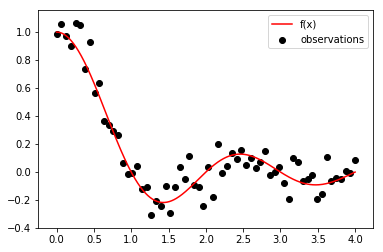

In [10]:
def target_function(x, noise_level=0):
    """convenience function to easily exchange the function to be fitted"""
    return(np.sinc(x) + noise_level*np.random.randn(len(x)))

# defines the x-interval for all following plots
x_interval = [0,4]

def generate_data (N_points, noise = 0):
    """automatically evaluates the target function on equally spaced points and adds some gaussian noise"""
    x_train = np.linspace(x_interval[0],x_interval[1],N_points)
    y_train = target_function(x_train, noise)
    return(x_train, y_train)

N_points=64
noise = 0.1

x_train, y_train = generate_data(N_points, noise)
x_dense = np.linspace(x_interval[0], x_interval[1], 512)
plt.plot(x_dense, target_function(x_dense,0), 'r',label=('f(x)'))
plt.scatter(x_train, y_train, c='black',label='observations')
plt.legend()
plt.show()



### Test with different hyperpatarmeters

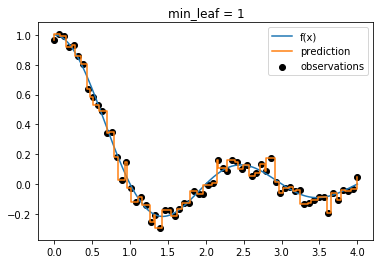

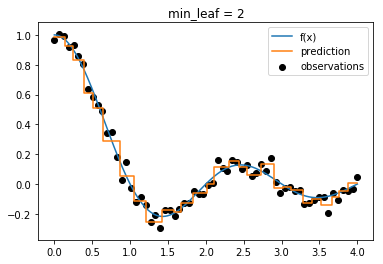

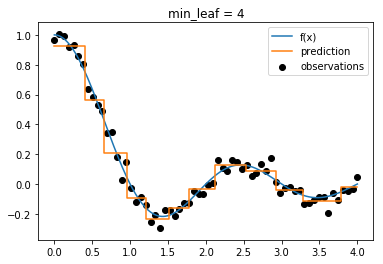

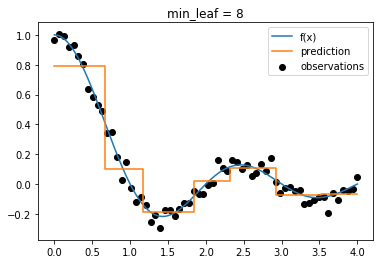

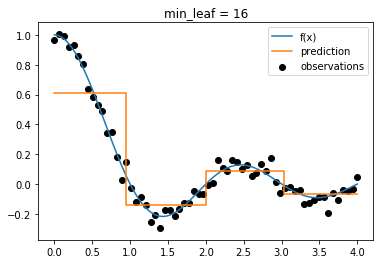

In [11]:
x_train, y_train = generate_data(N_points, 0.05)

for min_leaf in np.logspace(0,np.log2(N_points/4),5, base=2):
    tree = Tree(max_depth=N_points, min_leaf = int(min_leaf))
    tree.fit(x_train,y_train)
    ys = [tree.predict(x) for x in x_dense]
    plt.scatter(x_train, y_train, c='black', label='observations')
    plt.plot(x_dense, np.sinc(x_dense), label=('f(x)'))
    plt.step(x_dense,ys,label='prediction')
    plt.legend(loc=1)
    plt.title('min_leaf = %d'%int(min_leaf))
    plt.show()

## Random Foerst
Implementation of a random forest by bootstrap

In [12]:
class RandomForest(object):
    """A simple Random Forest"""
    def __init__ (self, num_trees = 64, min_leaf=1, max_depth = 32, datapoints_per_tree = 16):
        # initialize hyperparameters
        self.num_trees = num_trees
        self.min_leaf = min_leaf
        self.max_depth = max_depth
        self.datapoints_per_tree = datapoints_per_tree
        
        # attributes
        self.trees = []
    
    def fit(self, x, t):
        """ takes x and t and fits the specified number of trees to bootstrap samples"""
        self.forest=[]
        
        for i in range(self.num_trees):
            
            # create bootstrap sample
            indices = np.random.random_integers(len(x_train)-1, size=self.datapoints_per_tree)
            tree = Tree(max_depth=self.max_depth, min_leaf=self.min_leaf)
            tree.fit(x[indices], t[indices])
            self.trees.append(tree)
            
    def predict(self, x):
        tp = [t.predict(x) for t in self.trees]
        return(np.mean(tp))

Output of complete forest of random forest created by the traning

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(1, 63 + 1) instead


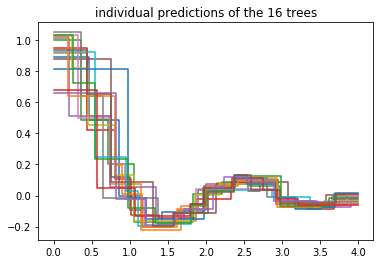

In [13]:
x_train, y_train = generate_data(64, 0.05)
rf = RandomForest(num_trees = 16,min_leaf = 4, datapoints_per_tree = 48)
rf.fit(x_train, y_train)
for i,t in enumerate(rf.trees):
    ys = [t.predict(x) for x in x_dense]
    plt.step(x_dense,ys, label='prediction %d'%i)
    plt.title('individual predictions of the %d trees'%int(min_leaf))
plt.show()

Two tests with different hyperparameters

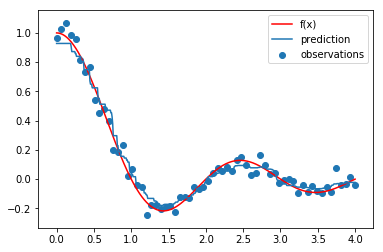

In [14]:
plt.plot(x_dense, target_function(x_dense,0), 'r',label=('f(x)'))
plt.scatter(x_train, y_train, label='observations')
y_forest = [rf.predict(x) for x in x_dense]
plt.plot(x_dense, y_forest, label='prediction')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(1, 63 + 1) instead


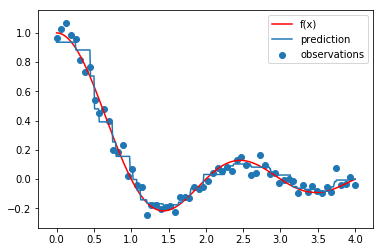

In [15]:
rf = RandomForest(num_trees = 4,min_leaf = 4, datapoints_per_tree = 64)
rf.fit(x_train, y_train)
plt.plot(x_dense, target_function(x_dense,0), 'r', label=('f(x)'))
plt.scatter(x_train, y_train, label='observations')
y_forest = [rf.predict(x) for x in x_dense]
plt.plot(x_dense, y_forest, label='prediction')
plt.legend()
plt.show()